In [ ]:
# 1: Import Required Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import classification_report, f1_score, confusion_matrix, precision_score, recall_score
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 2: Load Data
"""Load PELD dataset and VAD lexicon"""
# Load PELD dataset
data = pd.read_csv('Dyadic_PELD.tsv', sep='\t')

# Load VAD lexicon
vad_dict = {}
with open('NRC-VAD-Lexicon.txt', 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        if len(parts) == 4:
            word = parts[0]
            valence = float(parts[1])
            arousal = float(parts[2])
            dominance = float(parts[3])
            vad_dict[word] = [valence, arousal, dominance]

print(f"Loaded {len(vad_dict)} words from VAD lexicon")

# Extract all emotions from the dataset
emotions_all = []
for _, row in data.iterrows():
    emotions_all.extend([row['Emotion_1'], row['Emotion_2'], row['Emotion_3']])

# Analyze emotion distribution
emotion_counts = pd.Series(emotions_all).value_counts()
print("\nEmotion Distribution:")
print(emotion_counts)

Loaded 19971 words from VAD lexicon

Emotion Distribution:
neutral     8701
joy         3533
anger       2340
surprise    1889
fear        1346
sadness     1345
disgust      376
Name: count, dtype: int64


In [ ]:
# 3: Data Preprocessing Class
class DataProcessor:
    def __init__(self, vad_dict):
        self.word_to_idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx_to_word = {0: '<PAD>', 1: '<UNK>'}
        self.emotion_to_idx = {}
        self.idx_to_emotion = {}
        self.vad_dict = vad_dict

    def preprocess_text(self, text):
        """Tokenize and clean text"""
        text = re.sub(r'[^\w\s]', '', text.lower())
        return text.split()

    def build_vocabulary(self, texts):
        """Build vocabulary from text data"""
        word_freq = {}
        for text in texts:
            tokens = self.preprocess_text(text)
            for token in tokens:
                word_freq[token] = word_freq.get(token, 0) + 1

        # Add words to vocabulary
        for idx, (word, freq) in enumerate(sorted(word_freq.items(),
                                                  key=lambda x: x[1], reverse=True)[:10000]):
            self.word_to_idx[word] = idx + 2
            self.idx_to_word[idx + 2] = word

    def text_to_indices(self, text, max_length=50):
        """Convert text to indices"""
        tokens = self.preprocess_text(text)
        indices = []
        for token in tokens[:max_length]:
            indices.append(self.word_to_idx.get(token, 1))  # 1 is <UNK>

        # Pad sequence
        while len(indices) < max_length:
            indices.append(0)  # 0 is <PAD>

        return indices

    def parse_personality(self, personality_str):
        """Parse personality string to list of floats"""
        # Remove brackets and split by comma
        personality_str = personality_str.strip('[]')
        values = [float(x) for x in personality_str.split(', ')]
        return values

    def emotion_to_vad(self, emotion):
        """Map emotions to VAD values"""
        emotion_vad_mapping = {
            'anger': [-0.51, 0.59, 0.25],
            'disgust': [-0.60, 0.35, 0.11],
            'fear': [-0.62, 0.82, -0.43],
            'joy': [0.81, 0.51, 0.46],
            'neutral': [0.00, 0.00, 0.00],
            'sadness': [-0.63, -0.27, -0.33],
            'surprise': [0.40, 0.67, -0.13]
        }
        return emotion_vad_mapping.get(emotion.lower(), [0.0, 0.0, 0.0])


In [ ]:
# 4: Better Balancing Functions for PELD Dataset
def better_balanced_split(X, y, personalities, test_size=0.2, random_state=42):
    """Create a better balanced training set with reduced neutral class"""

    # First, do a stratified split to ensure both train and test have similar distributions
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(sss.split(X, y))

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    p_train, p_test = personalities[train_idx], personalities[test_idx]

    print("\n=== BEFORE BALANCING (Training Set) ===")
    print_class_distribution(y_train)

    # Better Moderate Balancing Method - equal classes
    def better_balancing(X, y, personalities):
        """Improved balancing to make all classes equal"""
        le = LabelEncoder()
        y_encoded = le.fit_transform(y)

        # Step 1: Calculate target count for all classes (based on second largest minority)
        class_counts = pd.Series(y).value_counts()

        # Get all counts except neutral
        non_neutral_counts = class_counts[class_counts.index != 'neutral']

        # Set target to the second largest minority plus 20% buffer
        target_count = int(non_neutral_counts.nlargest(2).iloc[1] * 1.2)

        print(f"\nTarget count per class: {target_count}")

        # Step 2: Sample all classes to target count
        balanced_indices = []

        for emotion in class_counts.index:
            emotion_mask = y == emotion
            emotion_indices = np.where(emotion_mask)[0]
            current_count = len(emotion_indices)

            if current_count > target_count:
                # Undersample if more than target
                sampled_indices = np.random.choice(emotion_indices, target_count, replace=False)
            else:
                # Oversample if less than target
                sampled_indices = np.random.choice(emotion_indices, target_count, replace=True)

            balanced_indices.extend(sampled_indices)

        balanced_indices = np.array(balanced_indices)

        # Shuffle the balanced indices
        np.random.shuffle(balanced_indices)

        X_balanced = X[balanced_indices]
        y_balanced = y[balanced_indices]
        p_balanced = personalities[balanced_indices]

        return X_balanced, y_balanced, p_balanced

    # Apply better balancing
    X_train_balanced, y_train_balanced, p_train_balanced = better_balancing(X_train, y_train, p_train)

    print("\n=== AFTER BALANCING (Training Set) ===")
    print_class_distribution(y_train_balanced)

    # Visualize before and after
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    pd.Series(y_train).value_counts().plot(kind='bar', ax=ax1, color='lightcoral')
    ax1.set_title('Training Set - Before Balancing')
    ax1.set_xlabel('Emotions')
    ax1.set_ylabel('Count')
    ax1.tick_params(axis='x', rotation=45)

    pd.Series(y_train_balanced).value_counts().plot(kind='bar', ax=ax2, color='lightgreen')
    ax2.set_title('Training Set - After Better Balancing')
    ax2.set_xlabel('Emotions')
    ax2.set_ylabel('Count')
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    return X_train_balanced, y_train_balanced, p_train_balanced, X_test, y_test, p_test

def print_class_distribution(y):
    """Print class distribution in a clean format"""
    counts = pd.Series(y).value_counts()
    print(f"{'Emotion':<12} {'Count':<10} {'Percentage':<12}")
    print("-" * 36)
    for emotion, count in counts.items():
        percentage = (count / len(y)) * 100
        print(f"{emotion:<12} {count:<10} {percentage:<12.2f}%")
    print("-" * 36)
    print(f"{'Total':<12} {len(y):<10} {100.0:<12.2f}%")


In [ ]:
# 5: Autoencoder Model Definition (PAEMP with Class Weights option)
class PersonalityAffectedEmotionMoodPredictor(nn.Module):
    """PAEMP: Personality-Affected Emotion and Mood Predictor - Autoencoder Version"""

    def __init__(self, vocab_size, embedding_dim=300, personality_dim=5,
                 emotion_classes=7, latent_dim=64, mood_dim=3):
        super(PersonalityAffectedEmotionMoodPredictor, self).__init__()

        self.model_name = "Autoencoder-PAEMP"

        # Text embedding layer
        self.text_embedding = nn.Embedding(vocab_size, embedding_dim)

        # Personality transformation
        self.personality_transform = nn.Linear(personality_dim, 32)

        # ENCODER: Compresses input to latent space
        self.encoder = nn.Sequential(
            nn.Linear(embedding_dim + 32, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

        # DECODER: Reconstructs original representation
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim)
        )

        # Emotion classifier (from latent space)
        self.emotion_classifier = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, emotion_classes)
        )

        # Mood predictor (latent space + personality)
        self.mood_base_predictor = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, mood_dim)
        )

        # Personality influence on mood
        self.personality_mood_weight = nn.Sequential(
            nn.Linear(personality_dim, 32),
            nn.ReLU(),
            nn.Linear(32, mood_dim)
        )

    def forward(self, text, personality):
        # Process text
        text_embeds = self.text_embedding(text).mean(dim=1)

        # Process personality
        personality_features = self.personality_transform(personality)

        # Combine
        combined = torch.cat([text_embeds, personality_features], dim=1)

        # Encode
        latent = self.encoder(combined)

        # Decode
        reconstructed = self.decoder(latent)

        # Predict emotion from latent space
        emotion_logits = self.emotion_classifier(latent)

        # Predict mood with personality influence
        base_mood = self.mood_base_predictor(latent)
        personality_weight = torch.sigmoid(self.personality_mood_weight(personality))
        influenced_mood = base_mood + (base_mood * personality_weight)

        return reconstructed, emotion_logits, influenced_mood


In [ ]:
# 6: Training Function with Class Weights option
def train_model(model, train_loader, val_loader, epochs=50, learning_rate=0.001, use_class_weights=False, class_weights=None):
    """Train the autoencoder model"""

    reconstruction_criterion = nn.MSELoss()

    if use_class_weights and class_weights is not None:
        emotion_criterion = nn.CrossEntropyLoss(weight=class_weights)
    else:
        emotion_criterion = nn.CrossEntropyLoss()

    mood_criterion = nn.MSELoss()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for batch_text, batch_personality, batch_emotion, batch_mood in tqdm(train_loader,
                                                                             desc=f"Epoch {epoch+1}/{epochs}"):
            optimizer.zero_grad()

            reconstructed, emotion_logits, mood_pred = model(batch_text, batch_personality)

            # Original text embeddings for reconstruction
            original_embeddings = model.text_embedding(batch_text).mean(dim=1)

            # Calculate losses
            reconstruction_loss = reconstruction_criterion(reconstructed, original_embeddings)
            emotion_loss = emotion_criterion(emotion_logits, batch_emotion)
            mood_loss = mood_criterion(mood_pred, batch_mood)

            # Combined loss with weights (reconstruction is key for autoencoder)
            total_loss = 0.4 * reconstruction_loss + 0.4 * emotion_loss + 0.2 * mood_loss

            total_loss.backward()
            optimizer.step()

            train_loss += total_loss.item()

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch_text, batch_personality, batch_emotion, batch_mood in val_loader:
                _, emotion_logits, _ = model(batch_text, batch_personality)

                _, predicted = torch.max(emotion_logits.data, 1)
                total += batch_emotion.size(0)
                correct += (predicted == batch_emotion).sum().item()

        accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}: Training Loss: {train_loss/len(train_loader):.4f}, "
              f"Validation Accuracy: {accuracy:.2f}%")


In [ ]:
# 7: Comprehensive Evaluation
def comprehensive_evaluation(model, test_loader, emotion_classes):
    """Evaluate the model comprehensively"""
    model.eval()

    all_emotion_preds = []
    all_emotion_targets = []
    all_mood_preds = []
    all_mood_targets = []

    with torch.no_grad():
        for batch_text, batch_personality, batch_emotion, batch_mood in test_loader:
            _, emotion_logits, mood_pred = model(batch_text, batch_personality)

            emotion_preds = torch.argmax(emotion_logits, dim=1)

            all_emotion_preds.extend(emotion_preds.cpu().numpy())
            all_emotion_targets.extend(batch_emotion.cpu().numpy())
            all_mood_preds.extend(mood_pred.cpu().numpy())
            all_mood_targets.extend(batch_mood.cpu().numpy())

    # Convert to numpy arrays
    all_emotion_preds = np.array(all_emotion_preds)
    all_emotion_targets = np.array(all_emotion_targets)
    all_mood_preds = np.array(all_mood_preds)
    all_mood_targets = np.array(all_mood_targets)

    # Emotion metrics
    macro_f1 = f1_score(all_emotion_targets, all_emotion_preds, average='macro')
    weighted_f1 = f1_score(all_emotion_targets, all_emotion_preds, average='weighted')

    print("\n=== EVALUATION RESULTS ===")
    print(f"Macro F1-score: {macro_f1:.4f}")
    print(f"Weighted F1-score: {weighted_f1:.4f}")

    # Detailed classification report
    print("\nClassification Report:")
    print(classification_report(all_emotion_targets, all_emotion_preds,
                              target_names=emotion_classes))

    # Mood metrics
    mood_mse = np.mean((all_mood_preds - all_mood_targets) ** 2, axis=0)
    print(f"\nMood Prediction MSE:")
    print(f"Valence: {mood_mse[0]:.4f}")
    print(f"Arousal: {mood_mse[1]:.4f}")
    print(f"Dominance: {mood_mse[2]:.4f}")

    # Visualization
    plt.figure(figsize=(15, 10))

    # Confusion matrix
    plt.subplot(2, 2, 1)
    cm = confusion_matrix(all_emotion_targets, all_emotion_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotion_classes,
                yticklabels=emotion_classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # F1 scores by emotion
    plt.subplot(2, 2, 2)
    emotion_f1_scores = []
    for i in range(len(emotion_classes)):
        f1 = f1_score(all_emotion_targets == i, all_emotion_preds == i)
        emotion_f1_scores.append(f1)

    plt.bar(emotion_classes, emotion_f1_scores)
    plt.title('F1 Score by Emotion')
    plt.xlabel('Emotions')
    plt.ylabel('F1 Score')
    plt.xticks(rotation=45)

    # Mood prediction error
    plt.subplot(2, 2, 3)
    plt.bar(['Valence', 'Arousal', 'Dominance'], mood_mse)
    plt.title('Mood Prediction MSE by Dimension')
    plt.ylabel('MSE')

    # Paper metrics comparison
    plt.subplot(2, 2, 4)
    paper_macro_f1 = 0.269
    paper_weighted_f1 = 0.392
    our_macro_f1 = macro_f1
    our_weighted_f1 = weighted_f1

    metrics = ['Macro F1', 'Weighted F1']
    paper_values = [paper_macro_f1, paper_weighted_f1]
    our_values = [our_macro_f1, our_weighted_f1]

    x = np.arange(len(metrics))
    width = 0.35

    plt.bar(x - width/2, paper_values, width, label='Paper Model')
    plt.bar(x + width/2, our_values, width, label='Our Autoencoder')

    plt.ylabel('Score')
    plt.title('Comparison with Paper Results')
    plt.xticks(x, metrics)
    plt.legend()

    plt.tight_layout()
    plt.show()

    return {
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1,
        'mood_mse': mood_mse,
        'emotion_predictions': all_emotion_preds,
        'emotion_targets': all_emotion_targets,
        'mood_predictions': all_mood_preds,
        'mood_targets': all_mood_targets
    }


APPLYING BETTER BALANCING METHOD ON PELD DATASET

=== BEFORE BALANCING (Training Set) ===
Emotion      Count      Percentage  
------------------------------------
neutral      6961       44.55       %
joy          2826       18.09       %
anger        1872       11.98       %
surprise     1511       9.67        %
fear         1077       6.89        %
sadness      1076       6.89        %
disgust      301        1.93        %
------------------------------------
Total        15624      100.00      %

Target count per class: 2246

=== AFTER BALANCING (Training Set) ===
Emotion      Count      Percentage  
------------------------------------
surprise     2246       14.29       %
sadness      2246       14.29       %
joy          2246       14.29       %
fear         2246       14.29       %
anger        2246       14.29       %
disgust      2246       14.29       %
neutral      2246       14.29       %
------------------------------------
Total        15722      100.00      %


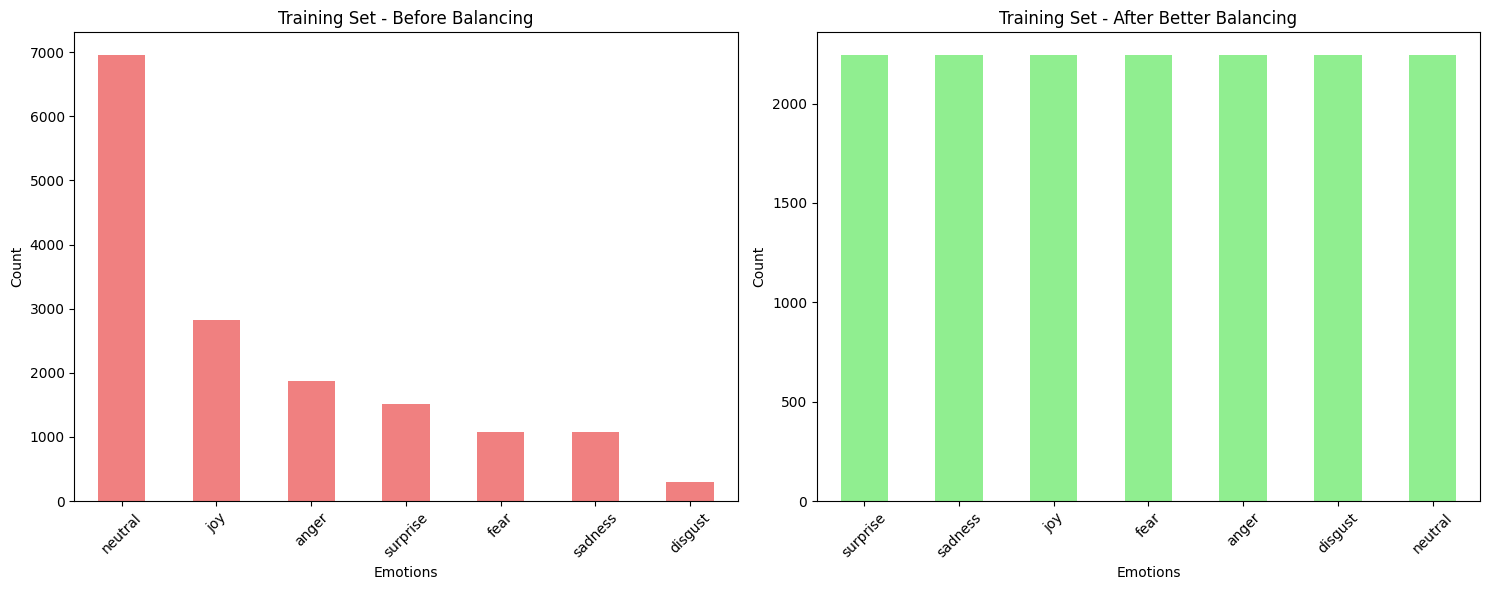


Dataset Information:
Source: PELD (Dyadic_PELD.tsv)
Training samples: 15722
Test samples: 3906
Vocabulary size: 6327

Model name: Autoencoder-PAEMP
This is a proper AUTOENCODER architecture with improved balancing

Starting training...


Epoch 1/30: 100%|██████████| 492/492 [00:15<00:00, 32.34it/s]


Epoch 1: Training Loss: 0.8142, Validation Accuracy: 9.55%


Epoch 2/30: 100%|██████████| 492/492 [00:12<00:00, 39.44it/s]


Epoch 2: Training Loss: 0.7789, Validation Accuracy: 16.77%


Epoch 3/30: 100%|██████████| 492/492 [00:12<00:00, 40.33it/s]


Epoch 3: Training Loss: 0.7328, Validation Accuracy: 23.68%


Epoch 4/30: 100%|██████████| 492/492 [00:12<00:00, 40.65it/s]


Epoch 4: Training Loss: 0.6880, Validation Accuracy: 21.61%


Epoch 5/30: 100%|██████████| 492/492 [00:12<00:00, 40.87it/s]


Epoch 5: Training Loss: 0.6576, Validation Accuracy: 16.77%


Epoch 6/30: 100%|██████████| 492/492 [00:11<00:00, 41.02it/s]


Epoch 6: Training Loss: 0.6300, Validation Accuracy: 29.42%


Epoch 7/30: 100%|██████████| 492/492 [00:12<00:00, 40.35it/s]


Epoch 7: Training Loss: 0.6041, Validation Accuracy: 23.58%


Epoch 8/30: 100%|██████████| 492/492 [00:12<00:00, 39.14it/s]


Epoch 8: Training Loss: 0.5787, Validation Accuracy: 31.18%


Epoch 9/30: 100%|██████████| 492/492 [00:12<00:00, 40.21it/s]


Epoch 9: Training Loss: 0.5692, Validation Accuracy: 37.40%


Epoch 10/30: 100%|██████████| 492/492 [00:11<00:00, 41.03it/s]


Epoch 10: Training Loss: 0.5504, Validation Accuracy: 33.77%


Epoch 11/30: 100%|██████████| 492/492 [00:12<00:00, 40.82it/s]


Epoch 11: Training Loss: 0.5292, Validation Accuracy: 32.74%


Epoch 12/30: 100%|██████████| 492/492 [00:11<00:00, 41.00it/s]


Epoch 12: Training Loss: 0.5178, Validation Accuracy: 36.56%


Epoch 13/30: 100%|██████████| 492/492 [00:12<00:00, 40.70it/s]


Epoch 13: Training Loss: 0.4995, Validation Accuracy: 25.04%


Epoch 14/30: 100%|██████████| 492/492 [00:13<00:00, 37.67it/s]


Epoch 14: Training Loss: 0.4862, Validation Accuracy: 34.77%


Epoch 15/30: 100%|██████████| 492/492 [00:12<00:00, 40.26it/s]


Epoch 15: Training Loss: 0.4786, Validation Accuracy: 27.39%


Epoch 16/30: 100%|██████████| 492/492 [00:12<00:00, 40.37it/s]


Epoch 16: Training Loss: 0.4704, Validation Accuracy: 26.63%


Epoch 17/30: 100%|██████████| 492/492 [00:12<00:00, 39.06it/s]


Epoch 17: Training Loss: 0.4517, Validation Accuracy: 39.25%


Epoch 18/30: 100%|██████████| 492/492 [00:12<00:00, 40.80it/s]


Epoch 18: Training Loss: 0.4468, Validation Accuracy: 35.66%


Epoch 19/30: 100%|██████████| 492/492 [00:12<00:00, 40.93it/s]


Epoch 19: Training Loss: 0.4370, Validation Accuracy: 30.31%


Epoch 20/30: 100%|██████████| 492/492 [00:12<00:00, 40.56it/s]


Epoch 20: Training Loss: 0.4271, Validation Accuracy: 36.33%


Epoch 21/30: 100%|██████████| 492/492 [00:12<00:00, 40.52it/s]


Epoch 21: Training Loss: 0.4187, Validation Accuracy: 36.69%


Epoch 22/30: 100%|██████████| 492/492 [00:12<00:00, 40.85it/s]


Epoch 22: Training Loss: 0.4149, Validation Accuracy: 39.38%


Epoch 23/30: 100%|██████████| 492/492 [00:12<00:00, 39.91it/s]


Epoch 23: Training Loss: 0.4113, Validation Accuracy: 37.56%


Epoch 24/30: 100%|██████████| 492/492 [00:12<00:00, 40.76it/s]


Epoch 24: Training Loss: 0.3974, Validation Accuracy: 31.67%


Epoch 25/30: 100%|██████████| 492/492 [00:12<00:00, 40.74it/s]


Epoch 25: Training Loss: 0.3899, Validation Accuracy: 37.99%


Epoch 26/30: 100%|██████████| 492/492 [00:12<00:00, 39.73it/s]


Epoch 26: Training Loss: 0.3947, Validation Accuracy: 40.19%


Epoch 27/30: 100%|██████████| 492/492 [00:12<00:00, 40.80it/s]


Epoch 27: Training Loss: 0.3823, Validation Accuracy: 42.04%


Epoch 28/30: 100%|██████████| 492/492 [00:12<00:00, 40.45it/s]


Epoch 28: Training Loss: 0.3707, Validation Accuracy: 39.17%


Epoch 29/30: 100%|██████████| 492/492 [00:12<00:00, 40.64it/s]


Epoch 29: Training Loss: 0.3725, Validation Accuracy: 41.01%


Epoch 30/30: 100%|██████████| 492/492 [00:12<00:00, 40.07it/s]


Epoch 30: Training Loss: 0.3674, Validation Accuracy: 40.91%

Starting evaluation...

=== EVALUATION RESULTS ===
Macro F1-score: 0.3883
Weighted F1-score: 0.4217

Classification Report:
              precision    recall  f1-score   support

       anger       0.34      0.47      0.40       468
     disgust       0.31      0.53      0.39        75
        fear       0.16      0.37      0.23       269
         joy       0.46      0.36      0.40       707
     neutral       0.61      0.38      0.47      1740
     sadness       0.33      0.43      0.38       269
    surprise       0.40      0.55      0.46       378

    accuracy                           0.41      3906
   macro avg       0.37      0.44      0.39      3906
weighted avg       0.47      0.41      0.42      3906


Mood Prediction MSE:
Valence: 0.2626
Arousal: 0.1339
Dominance: 0.0706


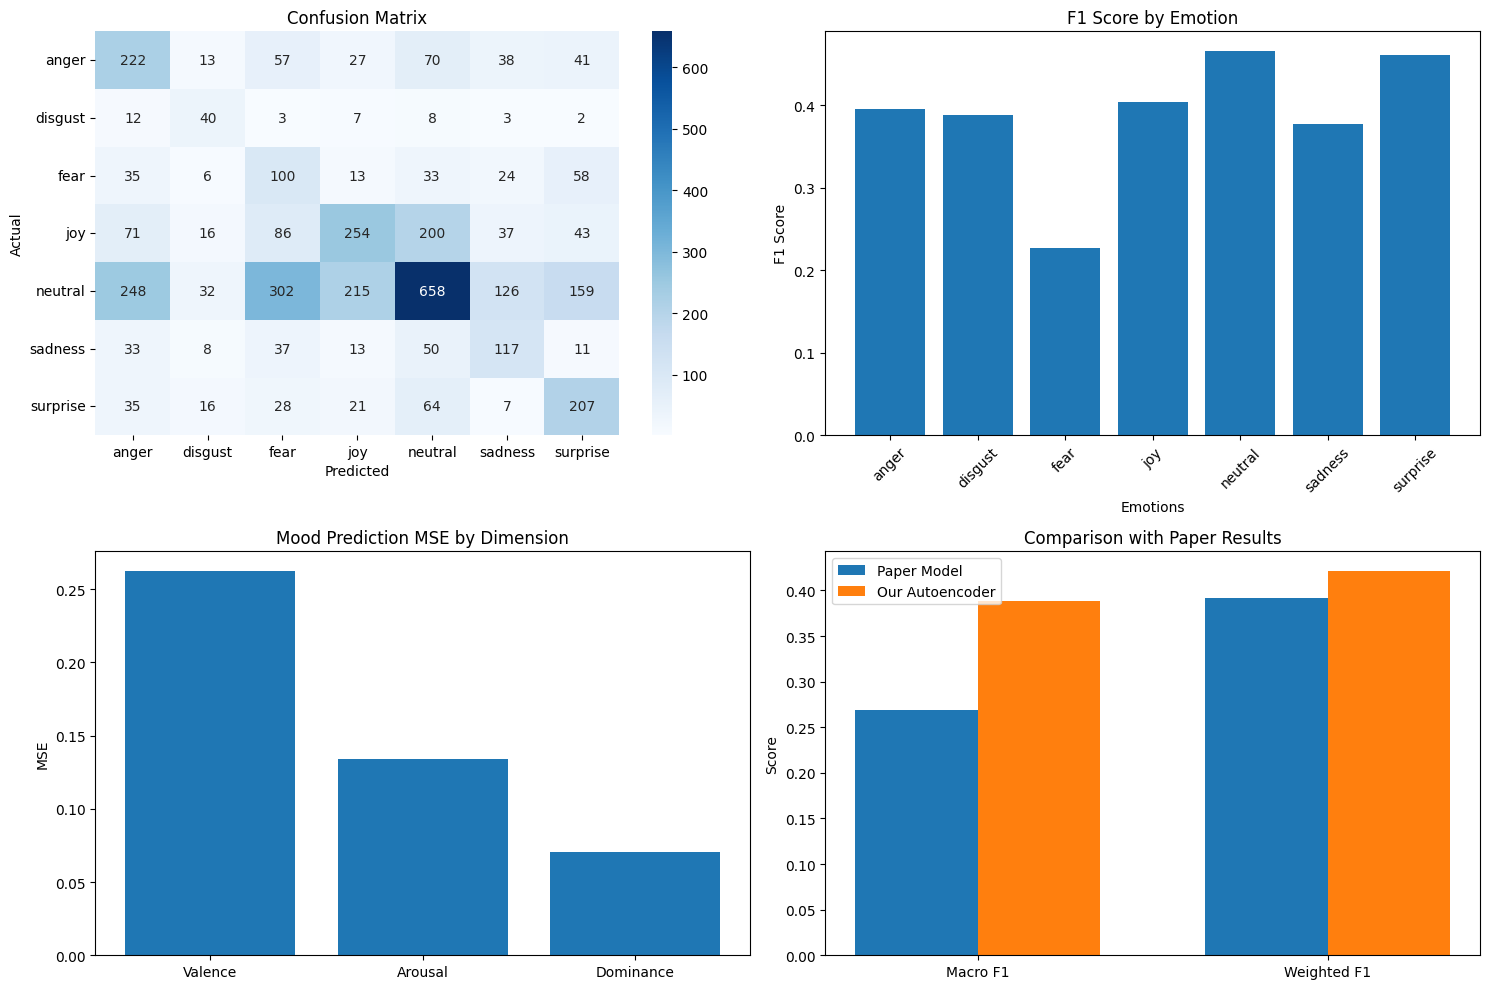


DATASET STATISTICS

==================== Autoencoder PAEMP (Better Balanced) Dataset Statistics ====================

Total Training Samples: 15722
Total Testing Samples: 3906
Total Samples: 19628
Train/Test Split: 80.1% / 19.9%

Training Set Class Distribution:
----------------------------------------
Emotion      Count      Percentage  
----------------------------------------
anger        2246       14.29       %
disgust      2246       14.29       %
fear         2246       14.29       %
joy          2246       14.29       %
neutral      2246       14.29       %
sadness      2246       14.29       %
surprise     2246       14.29       %
----------------------------------------
Total        15722      100.00      %

Testing Set Class Distribution:
----------------------------------------
Emotion      Count      Percentage  
----------------------------------------
anger        468        11.98       %
disgust      75         1.92        %
fear         269        6.89        %
joy   

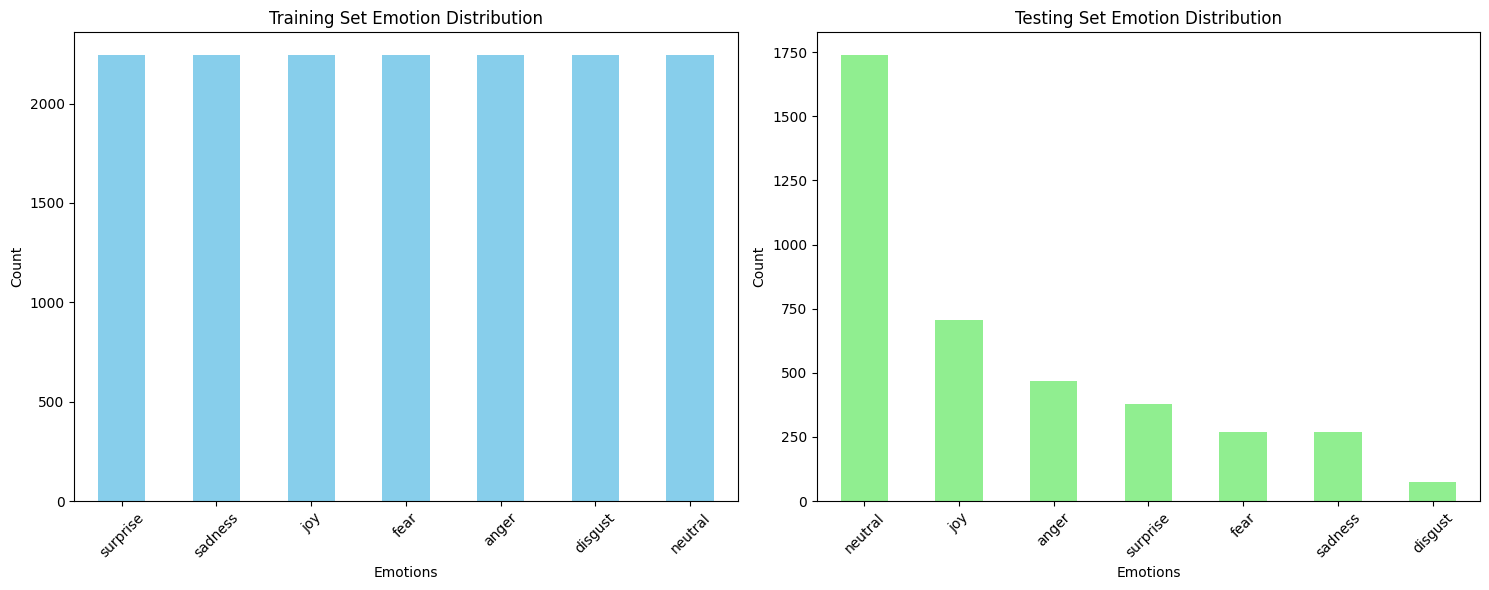

In [ ]:
# 8: Main Execution Pipeline with PELD Dataset and Better Balancing
# Process data from PELD dataset
processor = DataProcessor(vad_dict)

utterances = []
emotions = []
personalities = []

# Extract utterances and emotions from PELD dataset
for _, row in data.iterrows():
    utterances.extend([row['Utterance_1'], row['Utterance_2'], row['Utterance_3']])
    emotions.extend([row['Emotion_1'], row['Emotion_2'], row['Emotion_3']])
    # Parse personality as OCEAN values
    personality = processor.parse_personality(row['Personality'])
    personalities.extend([personality] * 3)

# Build vocabulary from PELD dataset
processor.build_vocabulary(utterances)

# Convert text to indices
X = []
for utterance in utterances:
    X.append(processor.text_to_indices(utterance))
X = np.array(X)

# Convert personalities to numpy array
personalities = np.array(personalities)

# Encode emotions
le = LabelEncoder()
emotions_encoded = le.fit_transform(emotions)

# Create emotion mapping
processor.emotion_to_idx = {emotion: idx for idx, emotion in enumerate(le.classes_)}
processor.idx_to_emotion = {idx: emotion for idx, emotion in enumerate(le.classes_)}

# Create mood labels (VAD values)
mood_labels = []
for emotion in emotions:
    mood_labels.append(processor.emotion_to_vad(emotion))
mood_labels = np.array(mood_labels)

# Apply better balanced split on PELD dataset
print("\n" + "="*50)
print("APPLYING BETTER BALANCING METHOD ON PELD DATASET")
print("="*50)

# Use better balanced split
X_train_balanced, y_train_balanced, p_train_balanced, X_test, y_test, p_test = better_balanced_split(
    X, np.array(emotions), personalities, test_size=0.2, random_state=42)

# Encode balanced emotions
y_train_balanced_encoded = le.transform(y_train_balanced)
y_test_encoded = le.transform(y_test)

# Create balanced mood labels
mood_train_balanced = []
for emotion in y_train_balanced:
    mood_train_balanced.append(processor.emotion_to_vad(emotion))
mood_train_balanced = np.array(mood_train_balanced)

mood_test = []
for emotion in y_test:
    mood_test.append(processor.emotion_to_vad(emotion))
mood_test = np.array(mood_test)

# Convert to tensors
X_train = torch.tensor(X_train_balanced, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.long)
y_train = torch.tensor(y_train_balanced_encoded, dtype=torch.long)
y_test = torch.tensor(y_test_encoded, dtype=torch.long)
p_train = torch.tensor(p_train_balanced, dtype=torch.float32)
p_test = torch.tensor(p_test, dtype=torch.float32)
m_train = torch.tensor(mood_train_balanced, dtype=torch.float32)
m_test = torch.tensor(mood_test, dtype=torch.float32)

# Create dataloaders from PELD data
train_dataset = torch.utils.data.TensorDataset(X_train, p_train, y_train, m_train)
test_dataset = torch.utils.data.TensorDataset(X_test, p_test, y_test, m_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"\nDataset Information:")
print(f"Source: PELD (Dyadic_PELD.tsv)")
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Vocabulary size: {len(processor.word_to_idx)}")

# Initialize autoencoder model
model = PersonalityAffectedEmotionMoodPredictor(vocab_size=len(processor.word_to_idx))

# Print model information
print(f"\nModel name: {model.model_name}")
print("This is a proper AUTOENCODER architecture with improved balancing")

# Train model
print("\nStarting training...")
train_model(model, train_loader, test_loader, epochs=30)

# Evaluate model
print("\nStarting evaluation...")
results = comprehensive_evaluation(model, test_loader, list(processor.idx_to_emotion.values()))

# Optional: Print additional dataset statistics
print("\n" + "="*50)
print("DATASET STATISTICS")
print("="*50)
print_dataset_statistics(X_train, y_train, X_test, y_test,
                         "Autoencoder PAEMP (Better Balanced)",
                         list(processor.idx_to_emotion.values()))

In [ ]:
# 9: Inference Function (separate emotion and mood prediction)
def predict_emotion_and_mood(model, utterance, personality, processor):
    """Predict emotion and mood for new input"""
    model.eval()

    # Preprocess text
    text_indices = processor.text_to_indices(utterance)
    text_tensor = torch.tensor([text_indices], dtype=torch.long)
    personality_tensor = torch.tensor([personality], dtype=torch.float32)

    with torch.no_grad():
        _, emotion_logits, mood_pred = model(text_tensor, personality_tensor)

        # Get emotion prediction
        emotion_idx = torch.argmax(emotion_logits, dim=1).item()
        emotion = processor.idx_to_emotion[emotion_idx]
        emotion_conf = torch.softmax(emotion_logits, dim=1)[0].numpy()

        # Get mood prediction
        mood_vad = mood_pred[0].numpy()

    print(f"\nUtterance: '{utterance}'")
    print(f"Personality (OCEAN): {personality}")
    print("\nPredictions:")
    print(f"Emotion: {emotion} (confidence: {emotion_conf[emotion_idx]:.4f})")
    print(f"Mood (VAD): Valence={mood_vad[0]:.3f}, Arousal={mood_vad[1]:.3f}, Dominance={mood_vad[2]:.3f}")

    # Show all emotion confidences
    print("\nAll emotion confidences:")
    for idx, conf in enumerate(emotion_conf):
        print(f"{processor.idx_to_emotion[idx]}: {conf:.4f}")

    return emotion, mood_vad

# Test with example
test_utterance = "I feel really nervous about the presentation tomorrow"
test_personality = [0.648, 0.375, 0.386, 0.58, 0.477]  # Chandler's personality

emotion, mood = predict_emotion_and_mood(model, test_utterance, test_personality, processor)



Utterance: 'I feel really nervous about the presentation tomorrow'
Personality (OCEAN): [0.648, 0.375, 0.386, 0.58, 0.477]

Predictions:
Emotion: joy (confidence: 0.6984)
Mood (VAD): Valence=0.544, Arousal=0.369, Dominance=0.300

All emotion confidences:
anger: 0.0223
disgust: 0.0000
fear: 0.0098
joy: 0.6984
neutral: 0.2429
sadness: 0.0226
surprise: 0.0039
